In [1]:
import os
import pickle
import numpy as np
import matplotlib.path as mpath
import scipy.sparse as sp
from scipy.interpolate import griddata
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator, CubicSpline, interp1d, PchipInterpolator, RegularGridInterpolator
from scipy.spatial import Delaunay
from scipy.ndimage import gaussian_filter
from spektral.data import Dataset, Graph
from spektral.data.loaders import DisjointLoader, SingleLoader
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.regularizers import l2
from spektral.layers import MessagePassing, GCNConv, GATConv, ECCConv
from sklearn.model_selection import train_test_split
from meshfunctions import *

In [48]:
def read_am_file(file_path,slices=None,sigma=0):    
    # Search for the binary data section marker "@1"
    marker = b"@1"
    with open(file_path, 'rb') as file:
        content = file.read()
        start = content.find(marker) + len(marker)
        
        # Assuming there are two newline characters after the "@1" marker
        # Adjust if necessary based on the actual file format
        start += 32
        
        # The total number of data points is the product of the lattice dimensions
        # Each point has 2 float components
        num_points = 512 * 512 * 1001 * 2
        
        # Set the file pointer to the start of the binary data and read it
        file.seek(start)
        data = np.fromfile(file, dtype=np.float32)
        
        # Reshape the data to the correct dimensions (512, 512, 1001, 2)
        # The last dimension is 2 for the two components of velocity at each grid point
        data = data.reshape((1001,512, 512, 2))

        if sigma != 0:
            data = gaussian_filter(data, sigma=(0, sigma, sigma, 0), mode='wrap')
        data = data*(1/data.std())
        # return data[:,200:400,200:400,:]
        # return data[:,:250,:250,100:800]
        if slices:
            data = data[slices[0],slices[1],slices[2],:]
            print(data.shape)
        return data
    
class IsInDomain:
    def __init__(self, nodesCurves):
        self.loops = [mpath.Path(nodesCurves[i]) for i in range(len(nodesCurves))]
        
    def __call__(self, points):
        return np.logical_and(self.loops[0].contains_points(points),np.logical_not(np.array([loop.contains_points(points) for loop in self.loops[1:]]).any(0)))
    
class Interp2dAcrossTimesteps:
    def __init__(self, data, x_coords, y_coords, kind='linear'):
        # self.data = data
        # self.x_coords = x_coords
        # self.y_coords = y_coords
        self.interp = [RegularGridInterpolator((x_coords,y_coords),  np.transpose(data[i,:,:,:],(1,0,2)), method=kind, bounds_error=False, fill_value=None) for i in range(data.shape[0])]

    def __call__(self, points, timesteps):
        return np.concatenate([self.interp[timestep](points) for timestep in timesteps],-1)
    
    def stack(self, points, timesteps):
        return np.stack([self.interp[timestep](points) for timestep in timesteps],0)
    
    
class Interp2Dslice:
    def __init__(self, interp2dAT, dT_arr):
        self.interp2dAT = interp2dAT
        self.dT_arr = dT_arr
        self.nDims = len(dT_arr)*2
    
    def __call__(self, points):
        return self.interp2dAT(points, self.dT_arr)
        
    
class Interp1DPeriodic:
    def __init__(self, x, y, kind = 'linear'):
        self.x = x
        self.y = y
        self.kind = kind
        self.spline = interp1d(self.x,self.y,kind=self.kind,axis=0)
    
    def __call__(self, x):
        return self.spline(x%self.x[-1])
    
class Interp1DPchipPeriodic:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.spline = PchipInterpolator(self.x,self.y,axis=0)
    
    def __call__(self, x):
        return self.spline(x%self.x[-1])

class Interp1dAcrossTimesteps:
    def __init__(self, dataB, distance, kind='pchip'):
        self.nDims = dataB.shape[-1]
        if kind == 'pchip':
            self.interp = [Interp1DPchipPeriodic(distance, dataB[i]) for i in range(dataB.shape[0])]
        else:
            self.interp = [Interp1DPeriodic(distance, dataB[i],kind=kind) for i in range(dataB.shape[0])]

    def __call__(self, x, timesteps):
        # return np.stack([self.interp[timestep](x) for timestep in timesteps],0)
        return np.concatenate([self.interp[timestep](x) for timestep in timesteps],-1)
    
class Interp1Dslice:
    def __init__(self, interp1dAT, dT_arr):
        self.interp1dAT = interp1dAT
        self.dT_arr = dT_arr
        self.nDims = len(dT_arr)*interp1dAT.nDims
    
    def __call__(self, x):
        return self.interp1dAT(x, self.dT_arr)

# input: file_path,dT_arr
def loadData(file_path, dT_arr, gradsBC = False, slices=None, sigma=0):
    data = read_am_file(file_path,slices=slices,sigma=sigma)

    NT = data.shape[0]
    NX = data.shape[1]
    NY = data.shape[2]
    Nv = data.shape[3]

    x = np.linspace(0, 1, NX)
    X,Y = np.meshgrid(x, x)

    # Comon for all timesteps
    nodes = np.stack([X.flatten(),Y.flatten()],-1)
    idxCorner = np.array([0,NX-1,NX*(NY-1),NX*NY-1],dtype=int)
    elementsBoundaryNodesOnly = np.array([[idxCorner[0],idxCorner[2],idxCorner[1]],[idxCorner[2],idxCorner[3],idxCorner[1]]],dtype=int)
    areaElementsBoundaryNodesOnly = np.array([0.5,0.5])
    isInDomain = IsInDomain([nodes[[idxCorner[0],idxCorner[1],idxCorner[3],idxCorner[2],idxCorner[0]]]])
    idxCurves = [np.concatenate([np.arange(NX),np.arange(2*NX-1,NY*NX,NX),np.arange(NY*NX-2,(NY-1)*NX-1,-1),np.arange((NY-2)*NX,-1,-NX)])]
    distance = [np.arange(0,idxCurve.shape[0])*1.0/(NX-1) for idxCurve in idxCurves]
    lengthCurves = [4]
    nodesCurves = [nodes[idxCurve] for idxCurve in idxCurves]
    idxCurveCorner = np.array([0,0,0,0],dtype=int)
    distanceCornerCurve = np.array([0,1,3,2],dtype=int)
    distance2boundary = np.min(np.stack([np.abs(X),np.abs(X-1),np.abs(Y),np.abs(Y-1)],-1),-1)
    interpD2B = RegularGridInterpolator((x,x),distance2boundary, method='linear', bounds_error=False, fill_value=None)
    interpBC = [Interp1DPeriodic(distance[0],nodesCurves[0],kind='linear')]
    normalCurves = [np.zeros((idxCurves[0].shape[0],2))]
    normalCurves[0][nodesCurves[0][:,0]==0,0] = -1
    normalCurves[0][nodesCurves[0][:,0]==1,0] = 1
    normalCurves[0][nodesCurves[0][:,1]==0,1] = -1
    normalCurves[0][nodesCurves[0][:,1]==1,1] = 1
    normalCurves[0] = normalCurves[0]/np.sqrt(np.sum(normalCurves[0]**2,1,keepdims=True))
    interpBN = [Interp1DPeriodic(distance[0],normalCurves[0],kind='linear')]
    # idxCorner = [0,511,512*512-1,512*511]
    idxCorner = [0,NX-1,NX*NY-1,NX*(NY-1)]

    interp2dAcrossTimesteps = Interp2dAcrossTimesteps(data, x, x)
    dataB = [data.reshape((NT,NX*NY,Nv))[:,idxCurves[0],:]]
    if gradsBC:
        nodesB = [nodes[idxCurves[0]]]
        nodesB_offset = [nodesB[0]-normalCurves[0]*1.0/(NX-1)]
        dataB_offset = [interp2dAcrossTimesteps.stack(nodesB_offset[0], np.arange(NT))]
        dataB_dn = [(dataB[0]-dataB_offset[0])*(NX-1)*0.7]
        dataB = [np.concatenate([dataB_dn[0],dataB[0]],-1)]
        
    interp1dAcrossTimesteps = [Interp1dAcrossTimesteps(dataB[0], distance[0], kind='pchip')]

    data_processed = []
    for i in range(-dT_arr[0],NT-dT_arr[-1]):
        # interpSE = lambda points, idxs = dT_arr+i: interp2dAcrossTimesteps(points, idxs)
        # interpSD = lambda points, idxs = [i]: interp2dAcrossTimesteps(points, idxs)
        interpSE = Interp2Dslice(interp2dAcrossTimesteps, dT_arr+i)
        interpSD = Interp2Dslice(interp2dAcrossTimesteps, [i])
        # interpBS = [lambda x,idxs=dT_arr+i: interp1dAcrossTimesteps[0](x, idxs)]
        interpBS = [Interp1Dslice(interp1dAcrossTimesteps[0], dT_arr+i)]
        data_processed.append(
            {'nodes': nodes,'elementsBoundaryNodesOnly': elementsBoundaryNodesOnly,'areaElementsBoundaryNodesOnly': areaElementsBoundaryNodesOnly,
            'isInDomainF': isInDomain,'interpSE': interpSE,'interpSD': interpSD,'interpD2B': interpD2B,'nodesCurves': nodesCurves,
            'lengthCurves': lengthCurves,'interpBC': interpBC,'interpBS': interpBS,'interpBN': interpBN,
            'distaceCornerCurve': distanceCornerCurve, 'idxCurveCorner': idxCurveCorner, 'idxCorner': idxCorner, 'dT': i, 'distance':  distance}
        )

    return data_processed

def GenerateGeometry2(p):
    g = cfg.Geometry()
    for i in range(p.shape[0]):
        g.point(list(p[i]))
    
    for i in range(4):
        g.line([i,(i+1)%4],marker=1)
    g.surface([0,1,2,3])
    return g

def MeshSurface(g,elSize):
    mesh = cfm.GmshMesh(g)
    mesh.elType = 2       # Degrees of freedom per node.
    mesh.dofsPerNode = 1     # Factor that changes element sizes.
    mesh.elSizeFactor = elSize # Element size Factor
    nodes, edof, dofs, bdofs, elementmarkers = mesh.create()

    elements = edof-1
    boundaryNodes = [np.array(bdofs[1])-1]
    internalNodes = np.setdiff1d(np.arange(nodes.shape[0]), np.concatenate(boundaryNodes))
    return nodes, elements, boundaryNodes, internalNodes

def computeLengthAlongCurve(nodesB):
    dl = np.sqrt(((nodesB[1:]-nodesB[:-1])**2).sum(1))
    l = np.cumsum(dl)
    l = np.concatenate([[0],l],0)
    return l

def RemeshData(data,elSize):
    nodes = data['nodes']
    idxSquare = data['idxCorner']
    nodesB = nodes[idxSquare]

    g = GenerateGeometry2(nodesB)
    nodes,elements,boundaryNodes,internalNodes = MeshSurface(g,elSize)
    boundaryNodes = np.concatenate(boundaryNodes)

    node_labels = data['interpSD'](nodes)

    nodesB_orig = data['nodesCurves'][0]
    distance = data['distance']
    bcVals = data['interpBS'][0](distance)[0]
    normalVals = data['interpBN'][0](distance)[0]
    bcVals = np.concatenate([bcVals,normalVals],-1)
    interpBC = LinearNDInterpolator(nodesB_orig,bcVals)
    vals_interp = interpBC(nodes)
    boundary_mask = np.zeros((nodes.shape[0], 1), dtype=np.float32)
    boundary_node_indices = np.array(boundaryNodes) # Ensure it's a numpy array
    boundary_mask[boundary_node_indices] = 1.0
    node_features = np.hstack((vals_interp, boundary_mask)).astype(np.float32)

    return {'nodes': nodes, 'elements': elements, 'node_features': node_features, 'node_labels': node_labels, 'boundaryNodes': boundaryNodes, 'internalNodes': internalNodes}

sigma = 20
encoder_data_history_range = (-30,0+1,10)
file_path = r'/Users/jakubhorsky/Documents/Programming/PythonProjects/SINNs_FYP_explore/TrainingData/TurbulentFlowData/4000.am'

slices = [slice(0,1001,1),slice(0,250,1),slice(250,500,1)]
data_train = loadData(file_path, np.arange(*encoder_data_history_range), gradsBC=True, slices=slices, sigma=sigma)
meshing_size = 0.1
data_train_remesh = [RemeshData(data_train[i],meshing_size) for i in range(0,len(data_train),3)]
slices_test = [slice(0,1001,1),slice(250,500,1),slice(250,500,1)]
data_test = loadData(file_path, np.arange(*encoder_data_history_range), gradsBC=True, slices=slices_test, sigma=sigma)
data_test_remesh = [RemeshData(data_test[i],meshing_size) for i in range(0,len(data_test),100)]

(1001, 250, 250, 2)


In [51]:
# --- Graph Conversion Function (from your query) ---
def ConvertFemSolutionToGraph(solution):
    """
    Converts a dictionary representing an FEM solution into a Spektral Graph object.
    """
    nodes_coords = solution['nodes'] # Renamed to avoid conflict with Graph attribute
    elements = solution['elements']
    boundaryNodes = solution['boundaryNodes']
    internalNodes = solution['internalNodes']
    node_features = solution['node_features'] # These are the 'x' attributes for the graph
    node_labels = solution['node_labels']     # These are the 'y' attributes for the graph

    N = nodes_coords.shape[0] # Number of nodes

    # Construct Adjacency Matrix (a)
    edge_list = set()
    for i, j, k in elements:
        edge_list.add(tuple(sorted((i, j))))
        edge_list.add(tuple(sorted((i, k))))
        edge_list.add(tuple(sorted((j, k))))

    row_indices = []
    col_indices = []
    for i, j in edge_list:
        row_indices.extend([i, j])
        col_indices.extend([j, i])

    adj_data = np.ones(len(row_indices), dtype=np.float32)
    adj_matrix_sparse = sp.csr_matrix((adj_data, (row_indices, col_indices)), shape=(N, N))

    # Construct Edge Features (e)
    adj_matrix_coo = adj_matrix_sparse.tocoo()
    source_nodes_idx = adj_matrix_coo.row
    target_nodes_idx = adj_matrix_coo.col

    # Calculate edge features:
    # - Relative position (dx, dy)
    # - Edge length
    relative_pos = nodes_coords[source_nodes_idx] - nodes_coords[target_nodes_idx] # Shape: (num_edges, 2)
    edge_length = np.linalg.norm(relative_pos, axis=1, keepdims=True) # Shape: (num_edges, 1)

    # Concatenate edge features: [dx, dy, length]
    edge_features = np.hstack((relative_pos, edge_length)).astype(np.float32)

    # Create the Spektral Graph object
    return Graph(x=node_features.astype(np.float32),  # Ensure float32 for consistency
                 a=adj_matrix_sparse,
                 e=edge_features.astype(np.float32), # Ensure float32 for consistency
                 y=node_labels,
                 # Store original FEM solution parts as custom attributes if needed
                 fem_nodes=nodes_coords, # Using 'fem_nodes' to avoid potential conflict if Spektral uses 'nodes'
                 fem_elements=elements,
                 fem_internalNodes=internalNodes,
                 fem_boundaryNodes=boundaryNodes)


# --- FEMDataset Class (from your query) ---
class FEMDataset(Dataset):
    """
    A Spektral Dataset for FEM simulation results.
    It takes a list of solution dictionaries and converts them to Graph objects.
    """
    def __init__(
        self,
        data_dict_list, # Expects a list of solution dictionaries
        cache_file="data/fem_dataset_graphs.pkl",
        force_regenerate=False, # Added for easier testing
        **kwargs
    ):
        self.data_dict_list = data_dict_list
        self.cache_file = cache_file
        self.force_regenerate = force_regenerate

        # Ensure cache directory exists
        cache_dir = os.path.dirname(self.cache_file)
        if cache_dir and not os.path.exists(cache_dir):
            os.makedirs(cache_dir)
            print(f"Created cache directory: {cache_dir}")

        super().__init__(**kwargs)

    def read(self):
        # 1) If we already generated & cached, just load that:
        if not self.force_regenerate and os.path.exists(self.cache_file):
            print(f"Loading cached dataset from {self.cache_file}")
            try:
                with open(self.cache_file, "rb") as f:
                    graphs = pickle.load(f)
                # Verify if the loaded graphs match the expected number from data_dict_list
                if len(graphs) == len(self.data_dict_list):
                    print(f"Successfully loaded {len(graphs)} graphs from cache.")
                    return graphs
                else:
                    print(f"Cache contains {len(graphs)} graphs, but expected {len(self.data_dict_list)}. Regenerating.")
            except Exception as e:
                print(f"Error loading from cache: {e}. Regenerating.")

        # 2) Otherwise, generate from scratch:
        print(f"Generating {len(self.data_dict_list)} new graph samples...")
        graphs = []
        for i, sol_dict in enumerate(self.data_dict_list):
            # print(f"Processing solution {i+1}/{len(self.data_dict_list)}")
            g = ConvertFemSolutionToGraph(sol_dict)
            graphs.append(g)

        # 3) Cache for next time:
        if self.cache_file:
            print(f"Caching {len(graphs)} graphs to {self.cache_file}")
            try:
                with open(self.cache_file, "wb") as f:
                    pickle.dump(graphs, f)
            except Exception as e:
                print(f"Error saving to cache: {e}")
        else:
            print("Cache file not specified. Skipping caching.")
            
        return graphs

# # --- Feature Normalization Function ---
# def normalize_dataset_features(dataset, epsilon=1e-8):
#     """
#     Normalizes node features (x) and edge features (e) across all graphs in a Spektral Dataset.
#     Uses Z-score normalization: (feature - mean) / (std_dev + epsilon).
#     Modifies the Graph objects in the dataset in-place.

#     Args:
#         dataset (spektral.data.Dataset): The dataset containing graphs to normalize.
#         epsilon (float): A small value added to the standard deviation for numerical stability.
#     """
#     if not dataset:
#         print("Dataset is empty. Nothing to normalize.")
#         return

#     # print("Starting feature normalization...")

#     # --- Collect Node Features (x) ---
#     all_node_features = []
#     for g in dataset:
#         if g.x is not None and g.x.shape[0] > 0: # Check if graph has node features
#             all_node_features.append(g.x)

#     if all_node_features:
#         all_node_features_np = np.vstack(all_node_features)
#         x_mean = np.mean(all_node_features_np, axis=0)
#         x_std = np.std(all_node_features_np, axis=0)
#         # print(f"Node feature global mean (shape {x_mean.shape}): {x_mean}")
#         # print(f"Node feature global std (shape {x_std.shape}): {x_std}")

#         # Apply normalization to node features
#         for g in dataset:
#             if g.x is not None and g.x.shape[0] > 0:
#                 g.x = (g.x - x_mean) / (x_std + epsilon)
#         # print("Node features normalized.")
#     else:
#         print("No node features found in the dataset to normalize.")

#     # --- Collect Edge Features (e) ---
#     all_edge_features = []
#     for g in dataset:
#         if g.e is not None and g.e.shape[0] > 0: # Check if graph has edge features
#             all_edge_features.append(g.e)

#     if all_edge_features:
#         all_edge_features_np = np.vstack(all_edge_features)
#         e_mean = np.mean(all_edge_features_np, axis=0)
#         e_std = np.std(all_edge_features_np, axis=0)
#         # print(f"Edge feature global mean (shape {e_mean.shape}): {e_mean}")
#         # print(f"Edge feature global std (shape {e_std.shape}): {e_std}")

#         # Apply normalization to edge features
#         for g in dataset:
#             if g.e is not None and g.e.shape[0] > 0:
#                 g.e = (g.e - e_mean) / (e_std + epsilon)
#         # print("Edge features normalized.")
#     else:
#         print("No edge features found in the dataset to normalize.")
#    # print("Feature normalization complete.")

# --- Feature Normalization Function (Modified) ---
def normalize_dataset_features(train_dataset, val_dataset=None, epsilon=1e-8):
    """
    Normalizes node features (x) and edge features (e).
    Calculates mean and std from train_dataset ONLY.
    Applies normalization to train_dataset and optionally to val_dataset.
    Modifies the Graph objects in the datasets in-place.

    Args:
        train_dataset (spektral.data.Dataset): The training dataset.
        val_dataset (spektral.data.Dataset, optional): The validation dataset. Defaults to None.
        epsilon (float): A small value for numerical stability.
    Returns:
        tuple: (x_mean, x_std, e_mean, e_std) calculated from the training set.
               Returns None for e_mean, e_std if no edge features.
               Returns None for x_mean, x_std if no node features.
    """
    if not train_dataset:
        print("Training dataset is empty. Nothing to normalize.")
        return None, None, None, None

    print("Starting feature normalization...")
    x_mean, x_std, e_mean, e_std = None, None, None, None

    # --- Collect and Normalize Node Features (x) ---
    all_train_node_features = []
    for g in train_dataset:
        if g.x is not None and g.x.shape[0] > 0:
            all_train_node_features.append(g.x)

    if all_train_node_features:
        all_train_node_features_np = np.vstack(all_train_node_features)
        x_mean = np.mean(all_train_node_features_np, axis=0)
        x_std = np.std(all_train_node_features_np, axis=0)
        print(f"Node feature global mean (from train_dataset, shape {x_mean.shape}): {x_mean}")
        print(f"Node feature global std (from train_dataset, shape {x_std.shape}): {x_std}")

        # Apply normalization to training node features
        for g in train_dataset:
            if g.x is not None and g.x.shape[0] > 0:
                g.x = (g.x - x_mean) / (x_std + epsilon)
        print("Training node features normalized.")

        # Apply normalization to validation node features (if provided)
        if val_dataset:
            for g in val_dataset:
                if g.x is not None and g.x.shape[0] > 0:
                    g.x = (g.x - x_mean) / (x_std + epsilon)
            print("Validation node features normalized.")
    else:
        print("No node features found in the training dataset to normalize.")

    # --- Collect and Normalize Edge Features (e) ---
    all_train_edge_features = []
    for g in train_dataset:
        if g.e is not None and g.e.shape[0] > 0:
            all_train_edge_features.append(g.e)

    if all_train_edge_features:
        all_train_edge_features_np = np.vstack(all_train_edge_features)
        e_mean = np.mean(all_train_edge_features_np, axis=0)
        e_std = np.std(all_train_edge_features_np, axis=0)
        print(f"Edge feature global mean (from train_dataset, shape {e_mean.shape}): {e_mean}")
        print(f"Edge feature global std (from train_dataset, shape {e_std.shape}): {e_std}")

        # Apply normalization to training edge features
        for g in train_dataset:
            if g.e is not None and g.e.shape[0] > 0:
                g.e = (g.e - e_mean) / (e_std + epsilon)
        print("Training edge features normalized.")

        # Apply normalization to validation edge features (if provided)
        if val_dataset:
            for g in val_dataset:
                if g.e is not None and g.e.shape[0] > 0:
                    g.e = (g.e - e_mean) / (e_std + epsilon)
            print("Validation edge features normalized.")
    else:
        print("No edge features found in the training dataset to normalize.")
    
    print("Feature normalization complete.")
    return x_mean, x_std, e_mean, e_std

# Generate (and cache) graphs:
dataset_train = FEMDataset(data_train_remesh,cache_file="data/cfd_dynamic_train_graphs.pkl",force_regenerate=True)
dataset_val = FEMDataset(data_test_remesh,cache_file="data/cfd_dynamic_test_graphs.pkl",force_regenerate=True)
x_mean, x_std, e_mean, e_std = normalize_dataset_features(dataset_train, dataset_val)
# normalize_dataset_features(dataset_train)
# normalize_dataset_features(dataset_val)

Generating 324 new graph samples...
Caching 324 graphs to data/cfd_dynamic_train_graphs.pkl
Generating 10 new graph samples...
Caching 10 graphs to data/cfd_dynamic_test_graphs.pkl
Starting feature normalization...
Node feature global mean (from train_dataset, shape (19,)): [-0.19311129  0.37274483  0.15566716 -0.28686276 -0.22490923  0.39108294
  0.16433601 -0.29402372 -0.25528702  0.40817356  0.17265637 -0.30160028
 -0.28485766  0.42367226  0.1805965  -0.30943373 -0.01706372 -0.00508415
  0.2777778 ]
Node feature global std (from train_dataset, shape (19,)): [2.1551142  1.4989268  0.64918834 0.7121361  2.1585     1.4865382
 0.65212435 0.70887345 2.159577   1.4731638  0.6550184  0.7060111
 2.156517   1.4599569  0.65775007 0.703611   0.54541576 0.5443289
 0.4478647 ]
Training node features normalized.
Validation node features normalized.
Edge feature global mean (from train_dataset, shape (3,)): [9.051939e-13 1.182294e-13 9.728065e-02]
Edge feature global std (from train_dataset, shape

In [93]:
def GetK_tf(nodes_el, A, r):
    # Get the stiffness matrix for a triangular elements, function is vectorized so that a batch of elements can be processed at once
    #   nodes_el - [N,3,2] tensor which containes the x,y positions of the 3 nodes of N triangles
    #   A - [2*r,2*r] tensor which defines the linear PDE coefficients
    #   r - number of latent variables

    # calculate the triangle area and the B matrix which is a derivative of the shape functions (B = div(N))
    b = (tf.roll(nodes_el[:,:,1],1,axis=1) - tf.roll(nodes_el[:,:,1],2,axis=1))
    b = tf.reshape(b,(-1,3,1))
    c = (tf.roll(nodes_el[:,:,0],2,axis=1) - tf.roll(nodes_el[:,:,0],1,axis=1))
    c = tf.reshape(c,(-1,3,1))
    Area = tf.abs(tf.matmul(tf.reshape(nodes_el[:,:,0],(-1,1,3)),b))/2
    I = tf.reshape(tf.eye(r),(1,r,r))
    B = tf.concat([
        tf.concat([b[:,0:1]*I, b[:,1:2]*I, b[:,2:3]*I],-1),
        tf.concat([c[:,0:1]*I, c[:,1:2]*I, c[:,2:3]*I],-1)
    ],-2)/(2*Area)
    B_T = tf.transpose(B,(0,2,1))
    return tf.matmul(tf.matmul(B_T,A),B)*Area # calculates the stiffness matrix

# def SolveFEM_tf(nodes, elements, boundaryNodes, l_BC, source_term, internalNodes, r, A_l):
#     """
#     Solve a 2D linear FEM problem using only TensorFlow operations.
    
#     Args:
#         nodes: TensorFlow tensor containing node coordinates
#         elements: List of element node indices
#         boundaryNodes: Indices of boundary nodes
#         BCfunc: Function to compute boundary conditions
#         alpha: Scalar parameter for boundary conditions
#         internalNodes: Indices of internal nodes
#         r: Number of degrees of freedom per node
#         A_l: Linear operator coefficient (optional)
#         A: Nonlinear operator function (optional)
    
#     Returns:
#         TensorFlow tensor with solution at all nodes
#     """
#     # Convert inputs to TensorFlow tensors if they aren't already
#     if not isinstance(nodes, tf.Tensor):
#         nodes = tf.convert_to_tensor(nodes, dtype=tf.float32)
#     if not isinstance(elements, tf.Tensor):
#         elements = tf.convert_to_tensor(elements, dtype=tf.int32)
#     if not isinstance(boundaryNodes, tf.Tensor):
#         boundaryNodes = tf.convert_to_tensor(boundaryNodes, dtype=tf.int32)
#     if not isinstance(internalNodes, tf.Tensor):
#         internalNodes = tf.convert_to_tensor(internalNodes, dtype=tf.int32)
#     if not isinstance(l_BC, tf.Tensor):
#         l_BC = tf.convert_to_tensor(l_BC, dtype=tf.float32)
#     if not isinstance(source_term, tf.Tensor):
#         source_term = tf.convert_to_tensor(source_term, dtype=tf.float32)
    
#     # Initialize solution vector
#     total_nodes = tf.shape(nodes)[0]
#     l = tf.zeros((total_nodes, r), dtype=tf.float32)
    
#     # Initialize global stiffness matrix
#     total_dofs = total_nodes * r
#     K = tf.zeros((total_dofs, total_dofs), dtype=tf.float32)
    
#     # Assemble the global stiffness matrix
#     for el in tf.unstack(elements):
#         # Create element DOF indices
#         el_indices = tf.reshape(
#             tf.stack([r * k + tf.range(r, dtype=tf.int32) for k in tf.unstack(el)]), [-1]
#         )
        
#         # Gather element nodes
#         nodes_el = tf.gather(nodes, el)
#         # Create mesh grid of indices
#         el_size = tf.shape(el_indices)[0]
#         idx_range = tf.range(el_size, dtype=tf.int32)
#         X_idx, Y_idx = tf.meshgrid(idx_range, idx_range)
        
        
#         # Get element stiffness matrix
#         nodes_el = tf.reshape(nodes_el, [1, 3, 2])
#         K_el = GetK_tf(nodes_el, A_l, r)[0]
        
#         # Update global stiffness matrix using scatter_nd_add
#         indices = tf.stack([
#             tf.gather(el_indices, tf.reshape(Y_idx, [-1])),
#             tf.gather(el_indices, tf.reshape(X_idx, [-1]))
#         ], axis=1)
        
#         K_el_flat = tf.reshape(K_el, [-1])
#         K = tf.tensor_scatter_nd_add(K, indices, K_el_flat)
    
    
#     # Create boundary and internal DOF indices
#     bc_indices = tf.reshape(
#         tf.stack([r * i + tf.range(r, dtype=tf.int32) for i in tf.unstack(boundaryNodes)]), [-1]
#     )
#     internal_indices = tf.reshape(
#         tf.stack([r * i + tf.range(r, dtype=tf.int32) for i in tf.unstack(internalNodes)]), [-1]
#     )
    
#     # Compute right-hand side vector
#     l_BC_flat = tf.reshape(l_BC, [-1, 1])

#     source_term = tf.reshape(source_term,(-1,1))
#     f = -tf.matmul(tf.gather(K, bc_indices, axis=1), l_BC_flat)
#     f -= source_term

    
#     # Extract the submatrix of K corresponding to internal DOFs
#     K_BC = tf.gather(tf.gather(K, internal_indices), internal_indices, axis=1)
#     f = tf.gather(f, internal_indices)
    
#     # Solve the system using TensorFlow's matrix_solve
#     l_internal = tf.linalg.solve(K_BC, f)
    
#     # Reshape the solution
#     n_CDOF = tf.shape(l_internal)[0] // r
#     l_internal = tf.reshape(l_internal, (n_CDOF, r))
    
#     # Update the solution vector
#     # Using tensor_scatter_nd_update to assign values
#     l = tf.tensor_scatter_nd_update(
#         l, 
#         tf.expand_dims(internalNodes, axis=1),
#         l_internal
#     )
    
#     l = tf.tensor_scatter_nd_update(
#         l, 
#         tf.expand_dims(boundaryNodes, axis=1),
#         tf.reshape(l_BC, (-1, r))
#     )
    
#     return l

 # -----------------------------------------------------------------------------
# Refactored SolveFEM_tf Function
# -----------------------------------------------------------------------------
def SolveFEM_tf(nodes, elements, boundaryNodes_indices, l_BC_values,
                 source_term_per_node, internalNodes_indices, r_dofs_per_node, A_l_material):
    """
    Solves a 2D linear FEM problem using TensorFlow operations, compatible with tf.function.
    Args:
        nodes (tf.Tensor): Node coordinates, shape [N_total_nodes, 2].
        elements (tf.Tensor): Element definitions (node indices), shape [N_elements, 3] for triangles.
        boundaryNodes_indices (tf.Tensor): Indices of boundary nodes, shape [N_boundary_nodes].
        l_BC_values (tf.Tensor): Prescribed values at boundary DOFs, shape [N_boundary_nodes, r_dofs_per_node].
        source_term_per_node (tf.Tensor): Source terms per node, shape [N_total_nodes, r_dofs_per_node].
        internalNodes_indices (tf.Tensor): Indices of internal nodes, shape [N_internal_nodes].
        r_dofs_per_node (tf.Tensor): Scalar int32, number of DOFs per node.
        A_l_material (tf.Tensor): Material property tensor for GetK_tf, e.g., shape [2*r, 2*r].
    Returns:
        tf.Tensor: Solution at all nodes, shape [N_total_nodes, r_dofs_per_node].
    """
    n_total_nodes = tf.shape(nodes)[0]
    n_elements = tf.shape(elements)[0]
    # nodes_per_element is static (3 for triangles), so tf.shape(elements)[1] is fine.
    nodes_per_element = tf.shape(elements)[1] 

    total_dofs = n_total_nodes * r_dofs_per_node
    K_global = tf.zeros((total_dofs, total_dofs), dtype=tf.float32)

    # --- Assemble Global Stiffness Matrix K_global ---
    elem_idx_counter = tf.constant(0, dtype=tf.int32)

    def stiffness_assembly_cond(current_elem_idx, k_matrix_acc):
        return current_elem_idx < n_elements

    def stiffness_assembly_body(current_elem_idx, k_matrix_acc):
        current_element_node_ids = tf.gather(elements, current_elem_idx) 

        nodes_el_for_K = tf.expand_dims(tf.gather(nodes, current_element_node_ids), axis=0)
        
        K_el_batched = GetK_tf(nodes_el_for_K, A_l_material, r_dofs_per_node)
        K_el = tf.squeeze(K_el_batched, axis=0) 

        r_range = tf.range(r_dofs_per_node, dtype=tf.int32) 
        current_element_node_ids_exp = tf.expand_dims(current_element_node_ids, axis=1)
        r_range_exp = tf.expand_dims(r_range, axis=0)
        
        global_dof_map_for_element = current_element_node_ids_exp * r_dofs_per_node + r_range_exp
        element_global_dof_indices = tf.reshape(global_dof_map_for_element, [-1]) 
        
        num_dofs_per_element_tensor = nodes_per_element * r_dofs_per_node # This will be a tensor
        
        # tf.meshgrid requires arguments to be known at graph construction if used directly for range.
        # However, num_dofs_per_element_tensor will be constant for a given r_dofs_per_node and nodes_per_element.
        # If nodes_per_element is truly dynamic (not fixed at 3), this tf.range would be an issue.
        # Assuming nodes_per_element is fixed (e.g. 3 for triangles), num_dofs_per_element_tensor is effectively constant.
        idx_grid_row, idx_grid_col = tf.meshgrid(tf.range(num_dofs_per_element_tensor), tf.range(num_dofs_per_element_tensor))
        
        global_row_indices = tf.gather(element_global_dof_indices, tf.reshape(idx_grid_row, [-1]))
        global_col_indices = tf.gather(element_global_dof_indices, tf.reshape(idx_grid_col, [-1]))
        
        scatter_indices = tf.stack([global_row_indices, global_col_indices], axis=1)
        k_el_flat_updates = tf.reshape(K_el, [-1])
        
        k_matrix_acc = tf.tensor_scatter_nd_add(k_matrix_acc, scatter_indices, k_el_flat_updates)
        
        return current_elem_idx + 1, k_matrix_acc

    _, K_global = tf.while_loop(
        stiffness_assembly_cond,
        stiffness_assembly_body,
        [elem_idx_counter, K_global],
        shape_invariants=[elem_idx_counter.get_shape(), tf.TensorShape([None, None])]
    )

    r_range_global = tf.range(r_dofs_per_node, dtype=tf.int32)

    boundaryNodes_indices_exp = tf.expand_dims(boundaryNodes_indices, axis=1)
    bc_global_dof_indices = tf.reshape(boundaryNodes_indices_exp * r_dofs_per_node + r_range_global, [-1])
    
    internalNodes_indices_exp = tf.expand_dims(internalNodes_indices, axis=1)
    internal_global_dof_indices = tf.reshape(internalNodes_indices_exp * r_dofs_per_node + r_range_global, [-1])

    F_source_global = tf.reshape(source_term_per_node, [total_dofs, 1])
    u_b_known_flat = tf.reshape(l_BC_values, [-1, 1]) 

    num_internal_dofs = tf.shape(internal_global_dof_indices)[0]
    num_boundary_dofs = tf.shape(bc_global_dof_indices)[0]

    # Initial F_eff_internal from source terms at internal DOFs
    F_eff_internal_base = tf.gather(F_source_global, internal_global_dof_indices)

    # Define functions for tf.cond
    def compute_Kib_effect():
        K_ib_loc = tf.gather(tf.gather(K_global, internal_global_dof_indices, axis=0), bc_global_dof_indices, axis=1)
        return F_eff_internal_base - tf.matmul(K_ib_loc, u_b_known_flat)

    def no_Kib_effect():
        return F_eff_internal_base

    # Use tf.cond to conditionally subtract K_ib * u_b effect
    condition = tf.logical_and(num_internal_dofs > 0, num_boundary_dofs > 0)
    F_eff_internal = tf.cond(condition,
                             true_fn=compute_Kib_effect,
                             false_fn=no_Kib_effect)
    
    u_i_solution = tf.zeros((num_internal_dofs, 1), dtype=tf.float32) 

    # Define functions for tf.cond for solving K_ii * u_i = F_eff_internal
    def solve_for_internal_dofs():
        K_ii_loc = tf.gather(tf.gather(K_global, internal_global_dof_indices, axis=0), internal_global_dof_indices, axis=1)
        K_ii_stable_loc = K_ii_loc + tf.eye(num_internal_dofs, dtype=tf.float32) * 1e-9
        return tf.linalg.solve(K_ii_stable_loc, F_eff_internal)

    def no_internal_dofs_solution():
        return u_i_solution # Returns the pre-initialized zeros

    # Use tf.cond to solve only if there are internal DOFs
    u_i_solution = tf.cond(num_internal_dofs > 0,
                           true_fn=solve_for_internal_dofs,
                           false_fn=no_internal_dofs_solution)

    l_solution_flat = tf.zeros((total_dofs,), dtype=tf.float32)
    
    # Define functions for tf.cond for scattering boundary values
    def scatter_boundary_values():
        return tf.tensor_scatter_nd_update(
            l_solution_flat,
            tf.expand_dims(bc_global_dof_indices, axis=1),
            tf.squeeze(u_b_known_flat, axis=1)
        )
    def no_scatter_boundary_values():
        return l_solution_flat
    
    l_solution_flat = tf.cond(num_boundary_dofs > 0,
                              true_fn=scatter_boundary_values,
                              false_fn=no_scatter_boundary_values)
    
    # Define functions for tf.cond for scattering internal values
    # Need to pass the current l_solution_flat to the true_fn
    def scatter_internal_values(current_l_flat):
        return tf.tensor_scatter_nd_update(
            current_l_flat, # Use the potentially updated flat solution
            tf.expand_dims(internal_global_dof_indices, axis=1),
            tf.squeeze(u_i_solution, axis=1)
        )
    def no_scatter_internal_values(current_l_flat):
        return current_l_flat

    l_solution_flat = tf.cond(num_internal_dofs > 0,
                              true_fn=lambda: scatter_internal_values(l_solution_flat), # Use lambda to pass current l_solution_flat
                              false_fn=lambda: no_scatter_internal_values(l_solution_flat))
        
    l_solution_all_nodes = tf.reshape(l_solution_flat, (n_total_nodes, r_dofs_per_node))
    
    return l_solution_all_nodes

def GetA(P_A,P_m):
    A = tf.matmul(P_A,P_A,transpose_a=True)
    A = tf.math.exp(P_m) * A / tf.sqrt(tf.reduce_mean(tf.square(A)))
    return A


class PatchedGCNConv(GCNConv):
    def call(self, inputs, mask=None):
        # inputs: a list [X, A] (or [X, A, E] depending on the layer)
        # mask:   can be None, a Tensor, or a list of Tensors
        if isinstance(mask, list) and mask and mask[0] is None:
            mask = None
        # Delegate to the real implementation
        # Note: super().call expects signature call(self, inputs, **kwargs)
        return super().call(inputs, mask=mask)
    

class PatchedGATConv(GATConv):
    def call(self, inputs, mask=None):
        if isinstance(mask, list) and mask and mask[0] is None:
            mask = None
        return super().call(inputs, mask=mask)

class PatchedECCConv(ECCConv):
    def call(self, inputs, mask=None):
        if isinstance(mask, list) and mask and mask[0] is None:
            mask = None
        return super().call(inputs, mask=mask) 

# --- main model -----------------------------------------------------------
class FEMGNN(tf.keras.Model):                # Sub-classing is the recommended way
    def __init__(self, hidden_dim, n_enc_layers, n_dec_layers, out_dim, r, ecc_conv_kernel_network = None, **kwargs):
        """
        hidden_dim : units in the encoder GCNs
        out_dim    : units in the final GCN output
        r          : scalar field dimensionality (2 in your example)
        """
        super().__init__(**kwargs)

        # ===== trainable FEM parameters ===================================
        # P_A_initializer = tf.keras.initializers.RandomNormal(stddev=0.01)
        P_A_initializer = tf.keras.initializers.Identity(gain=0.01)
        self.P_A = self.add_weight(
            name="P_A",
            shape=(2 * r, 2 * r),
            initializer=P_A_initializer,
            trainable=True,
        )
        self.P_m = self.add_weight(
            name="P_m",
            shape=(),                       # scalar
            initializer="zeros",
            trainable=True,
        )
        self.r = tf.constant(r, dtype=tf.int32)

        self.ecc_conv_kernel_network = ecc_conv_kernel_network

        # ===== graph encoder ==============================================
        self.in_dense = tf.keras.layers.Dense(hidden_dim, activation=None)
        self.n_enc_layers = n_enc_layers
        self.ecc_conv_kernel_network = ecc_conv_kernel_network
        self.enc_gcn_arr = [PatchedECCConv(hidden_dim, activation="relu", kernel_network=self.ecc_conv_kernel_network) for _ in range(self.n_enc_layers)]
        self.enc_mlp_arr = [Dense(hidden_dim, activation="relu") for _ in range(self.n_enc_layers)]

        # project encoded features to boundary values and source term
        self.to_lBC      = tf.keras.layers.Dense(r, activation=None)   # per-node Dirichlet BC
        self.to_src_term = tf.keras.layers.Dense(r, activation=None)   # per-node RHS/source

        # ===== graph decoder ==============================================
        self.latent_dense = tf.keras.layers.Dense(hidden_dim, activation=None)
        self.n_dec_layers = n_dec_layers
        self.dec_gcn_arr = [PatchedECCConv(hidden_dim, activation="relu", kernel_network=self.ecc_conv_kernel_network) for _ in  range(self.n_dec_layers)]
        self.dec_mlp_arr = [Dense(hidden_dim, activation="relu") for _ in range(self.n_enc_layers)]
        # self.out_gcn = PatchedGCNConv(out_dim,    activation=None)
        self.out_dense = tf.keras.layers.Dense(out_dim, activation=None)   # per-node RHS/source

    def call(self, inputs, training=False):
        """
        inputs = { 'x': node features  [N,F],
                   'a': SparseTensor   [N,N],
                   'mesh': dict(nodes, elements, boundaryNodes, internalNodes, r) }
        """
        x, a, e, mesh = inputs["x"], inputs["a"], inputs["e"], inputs["mesh"]

        # ---------- 1) encode --------------------------------------------
        h = self.in_dense(x)
        for i in range(self.n_enc_layers):
            h_gcn  = self.enc_gcn_arr[i]([h, a, e], training=training)
            h_mlp = self.enc_mlp_arr[i](h,training=training)
            h = h_gcn + h_mlp + h
            # h = h_mlp + h


        # ---------- 2) predict BC & RHS ----------------------------------
        l_BC       = self.to_lBC(tf.gather(h, mesh["boundaryNodes"]  , axis=0))                 # [N_boundary,r]
        source     = self.to_src_term(h)            # [N,r]

        # ---------- 3) assemble elliptic system coefficients --------------------------
        A_l = GetA(self.P_A, self.P_m)              # trainable & differentiable
        # print(A_l)

        # ---------- 4) FEM solve (autograd-friendly) ----------------------
        l_pred = SolveFEM_tf(mesh["nodes"],
                             mesh["elements"],
                             mesh["boundaryNodes"],
                             l_BC,
                             source,
                             mesh["internalNodes"],
                             self.r,
                             A_l)                   # returns [N,r], differentiable

        # ---------- 5) concatenate and decode ----------------------------
        h = self.latent_dense(l_pred)
        # h = self.latent_dense(tf.concat([h, l_pred], axis=-1))
        for i in range(self.n_dec_layers):
            # h_gcn = self.dec_gcn_arr[i]([h, a, e], training=training)
            h_mlp = self.dec_mlp_arr[i](h,training=training)
            # h = h_gcn + h_mlp + h
            h = h_mlp + h
        
        out = self.out_dense(h)

        return out, A_l                     # we expose l_pred for monitoring


In [ ]:
import tensorflow as tf
import numpy as np
import scipy.sparse

# --- Determine Fixed Feature Dimensions ---
# It's best to explicitly define these based on your dataset's characteristics.
# For example, if you load your dataset:
# dataset_train, dataset_val = load_my_fem_data()
# sample_graph = dataset_train[0] # Or dataset_val[0]
#
sample_graph = dataset_train[0]
F_x_dim = sample_graph.x.shape[1]
F_e_dim = sample_graph.e.shape[1]
F_y_dim = sample_graph.y.shape[1]
D_nodes_dim = sample_graph.fem_nodes.shape[1]
nodes_per_element_dim = sample_graph.fem_elements.shape[1]

# --- Define Input Signatures ---
common_input_signature = [
    tf.TensorSpec(shape=[None, F_x_dim], dtype=tf.float32, name="x"),
    tf.SparseTensorSpec(shape=[None, None], dtype=tf.float32),
    tf.TensorSpec(shape=[None, F_e_dim], dtype=tf.float32, name="e"), # Shape [0, F_e_dim] if no edges/features
    tf.TensorSpec(shape=[None, F_y_dim], dtype=tf.float32, name="y"),
    {
        "nodes": tf.TensorSpec(shape=[None, D_nodes_dim], dtype=tf.float32, name="mesh_nodes"),
        "elements": tf.TensorSpec(shape=[None, nodes_per_element_dim], dtype=tf.int32, name="mesh_elements"),
        "boundaryNodes": tf.TensorSpec(shape=[None], dtype=tf.int32, name="mesh_boundaryNodes"),
        "internalNodes": tf.TensorSpec(shape=[None], dtype=tf.int32, name="mesh_internalNodes"),
    }
]

# --- Create Model, Loss, Optimizer ---
# loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.3e-3) # Use learning_rate
# r = 4
# model = FEMGNN(hidden_dim=64, n_enc_layers=2, n_dec_layers=2, out_dim=F_y_dim, r=r, ecc_conv_kernel_network=[64,64])


# --- tf.function decorated training step ---
@tf.function(input_signature=common_input_signature)
def train_step(x_in, a_in, e_in, y_in, mesh_in):
    with tf.GradientTape() as tape:
        # Note: The model receives the dictionary directly as its first argument.
        # Ensure FEMGNN's call method expects: model_inputs, training=True
        # where model_inputs = {"x": x_in, "a": a_in, "e": e_in, "mesh": mesh_in}
        predictions, A_l = model({"x": x_in, "a": a_in, "e": e_in, "mesh": mesh_in}, training=True)
        loss = loss_fn(y_in, predictions)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, A_l

# --- tf.function decorated evaluation step ---
@tf.function(input_signature=common_input_signature)
def evaluate_step(x_in, a_in, e_in, y_in, mesh_in):
    predictions, A_l = model({"x": x_in, "a": a_in, "e": e_in, "mesh": mesh_in}, training=False)
    loss = loss_fn(y_in, predictions)
    return loss, A_l

# --- Helper function to convert graph object to tensors ---
def prepare_graph_inputs(g_object, expected_F_e_dim):
    x_tensor = tf.convert_to_tensor(g_object.x, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(g_object.y, dtype=tf.float32)
    e_tensor = tf.convert_to_tensor(g_object.e, dtype=tf.float32)

    # Handle adjacency matrix
    A_csr = g_object.a.tocsr()
    A_coo = A_csr.tocoo()
    indices = np.vstack((A_coo.row, A_coo.col)).T
    a_tf_sparse = tf.SparseTensor(indices=indices, values=A_coo.data, dense_shape=A_coo.shape)
    a_tf_sparse = tf.sparse.reorder(a_tf_sparse)

    mesh_dict_tf = {
        "nodes": tf.convert_to_tensor(g_object.fem_nodes, tf.float32),
        "elements": tf.convert_to_tensor(g_object.fem_elements, tf.int32),
        "boundaryNodes": tf.convert_to_tensor(g_object.fem_boundaryNodes, tf.int32),
        "internalNodes": tf.convert_to_tensor(g_object.fem_internalNodes, tf.int32),
    }
    return x_tensor, a_tf_sparse, e_tensor, y_tensor, mesh_dict_tf

# --- Training Loop ---
n_epochs = 20
history = {'loss': [], 'val_loss': []}

print(f"Using fixed feature dimensions: NodeFeats={F_x_dim}, EdgeFeats={F_e_dim}, TargetFeats={F_y_dim}, NodeCoords={D_nodes_dim}, NodesPerElem={nodes_per_element_dim}")

for epoch in range(1, n_epochs + 1):
    epoch_loss_sum = 0.0
    np.random.shuffle(dataset_train) # Shuffle the actual list of graph objects
    dataset_train_sub = dataset_train[::] # Or however you subset

    for i, g in enumerate(dataset_train_sub):
        x_g, a_g, e_g, y_g, mesh_g = prepare_graph_inputs(g, F_e_dim)
        loss_val, _ = train_step(x_g, a_g, e_g, y_g, mesh_g)
        epoch_loss_sum += loss_val.numpy() # Add .numpy() to get Python float
        current_avg_loss = epoch_loss_sum / (i + 1)
        print(f"\rEpoch {epoch}/{n_epochs};  Iteration = {i+1}/{len(dataset_train_sub)};  Loss = {current_avg_loss:.4g}", end='')
    
    avg_epoch_loss = epoch_loss_sum / len(dataset_train_sub)
    history['loss'].append(avg_epoch_loss)

    val_loss_sum = 0.0
    for g_val in dataset_val:
        x_v, a_v, e_v, y_v, mesh_v = prepare_graph_inputs(g_val, F_e_dim)
        loss_v, _ = evaluate_step(x_v, a_v, e_v, y_v, mesh_v)
        val_loss_sum += loss_v.numpy()
    
    avg_val_loss = val_loss_sum / len(dataset_val)
    history['val_loss'].append(avg_val_loss)
    print(f";  Val Loss = {avg_val_loss:.4g}")

Using fixed feature dimensions: NodeFeats=19, EdgeFeats=3, TargetFeats=2, NodeCoords=2, NodesPerElem=3


/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/ipykernel_65712/1431603075.py:89: UserWarning: you are shuffling a 'FEMDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(dataset_train) # Shuffle the actual list of graph objects
/Users/jakubhorsky/Documents/Programming/PythonProjects/SIGNAL/spektralenv/lib/python3.9/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'femgnn_28', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 1/20;  Iteration = 324/324;  Loss = 1.647;  Val Loss = 0.2133
Epoch 2/20;  Iteration = 324/324;  Loss = 0.05433;  Val Loss = 0.14
Epoch 3/20;  Iteration = 324/324;  Loss = 0.03294;  Val Loss = 0.1121
Epoch 4/20;  Iteration = 324/324;  Loss = 0.02694;  Val Loss = 0.1145
Epoch 5/20;  Iteration = 324/324;  Loss = 0.02178;  Val Loss = 0.09063
Epoch 6/20;  Iteration = 324/324;  Loss = 0.03232;  Val Loss = 0.08456
Epoch 7/20;  Iteration = 324/324;  Loss = 0.01757;  Val Loss = 0.08217
Epoch 8/20;  Iteration = 324/324;  Loss = 0.03083;  Val Loss = 0.07015
Epoch 9/20;  Iteration = 324/324;  Loss = 0.01521;  Val Loss = 0.06737
Epoch 10/20;  Iteration = 324/324;  Loss = 0.03802;  Val Loss = 0.06271
Epoch 11/20;  Iteration = 324/324;  Loss = 0.01232;  Val Loss = 0.05904
Epoch 12/20;  Iteration = 324/324;  Loss = 0.01279;  Val Loss = 0.05667
Epoch 13/20;  Iteration = 324/324;  Loss = 0.01666;  Val Loss = 0.09205
Epoch 14/20;  Iteration = 324/324;  Loss = 0.02302;  Val Loss = 0.07655
Epoch 15/

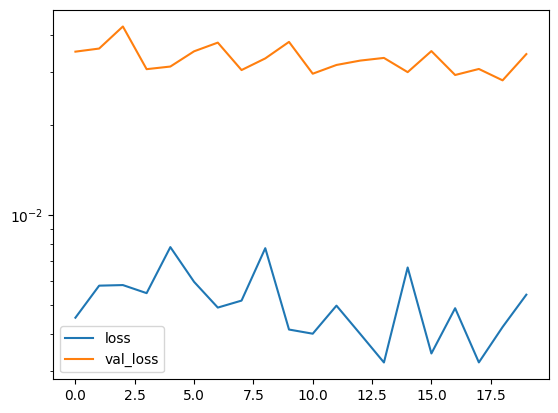

In [84]:
import matplotlib.pyplot as plt
plt.plot(history['loss'],label='loss')
plt.plot(history['val_loss'],label='val_loss')
plt.gca().set_yscale('log')
plt.legend()

In [ ]:
def evaluate_graph(g):
    # --- convert NumPy/SciPy → TF ------------------------------------
    x  = tf.convert_to_tensor(g.x, dtype=tf.float32)
    e = tf.convert_to_tensor(g.e, dtype=tf.float32)
    y  = tf.convert_to_tensor(g.y, dtype=tf.float32)

    A_csr = g.a.tocsr()             # ensure CSR
    A_coo = A_csr.tocoo()           # easy access to .row/.col/.data
    indices = np.vstack((A_coo.row, A_coo.col)).T
    values  = A_coo.data
    shape   = A_coo.shape

    a_tf = tf.SparseTensor(indices=indices,
                        values=values,
                        dense_shape=shape) 
    a_tf = tf.sparse.reorder(a_tf) 

    mesh    = dict(nodes         = tf.convert_to_tensor(g.fem_nodes, tf.float32),
                    elements      = tf.convert_to_tensor(g.fem_elements, tf.int32),
                    boundaryNodes = tf.convert_to_tensor(g.fem_boundaryNodes, tf.int32),
                    internalNodes = tf.convert_to_tensor(g.fem_internalNodes, tf.int32),
                    )

    preds, A_l = model({"x": x, "a": a_tf, "e": e, "mesh": mesh}, training=True)
    loss     = loss_fn(y, preds)
    return loss, A_l

# @tf.function                                     # XLA speeds things up
def train_on_graph(g):
    with tf.GradientTape() as tape:
        loss, A_l = evaluate_graph(g)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss, A_l


r = 4

loss_fn    = tf.keras.losses.MeanSquaredError()
optimizer  = tf.keras.optimizers.Adam(1e-3)
model      = FEMGNN(hidden_dim=16, n_enc_layers=0, n_dec_layers=0, out_dim=2, r=r, ecc_conv_kernel_network=[32,32])   # adjust r/out_dim as needed

# --------- loop over epochs ----------------------------------------------
n_epochs = 20
history = {'loss': [], 'val_loss': []}
for epoch in range(1, n_epochs+1):
    epoch_loss = 0.0
    np.random.shuffle(dataset_train)
    dataset_train_sub = dataset_train[::10]
    for i, g in enumerate(dataset_train_sub):                       # just iterate – no Loader needed
        loss, A_l = train_on_graph(g)
        epoch_loss += loss
        epoch_loss_tmp = epoch_loss/(i+1)
        print(f"\repoch {epoch:03d}; itt = {i}/{len(dataset_train_sub)};  loss = {epoch_loss_tmp:.4g}",end='')
    epoch_loss = epoch_loss/len(dataset_train_sub)
    history['loss'].append(epoch_loss)

    val_loss = 0.0
    for g in dataset_val:                       # just iterate – no Loader needed
        loss,_ = evaluate_graph(g)
        val_loss += loss
    val_loss = val_loss/len(dataset_val)
    history['val_loss'].append(val_loss)
    print(f";  val_loss = {val_loss:.4g}")

    # print(A_l.numpy())

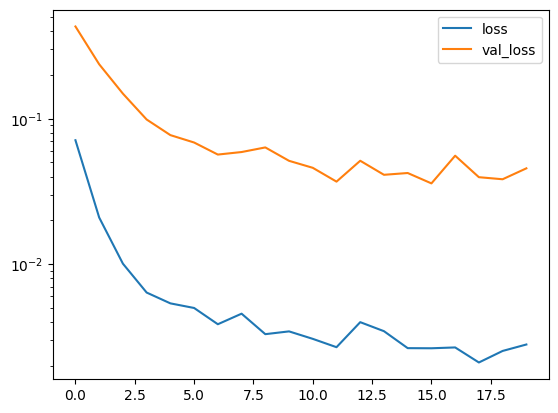

In [57]:
import matplotlib.pyplot as plt
plt.plot(history['loss'],label='loss')
plt.plot(history['val_loss'],label='val_loss')
plt.gca().set_yscale('log')
plt.legend()